In [ ]:
import os
from itertools import product
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from joblib import Parallel, delayed
from tqdm.auto import tqdm

load_dotenv()

# check if MPL_STYLE is set in the environment, else use default
if "MPL_STYLE" not in os.environ:
    os.environ["MPL_STYLE"] = "seaborn-v0_8-notebook"
plt.style.use(os.environ["MPL_STYLE"])

In [2]:
metric_dict = {
    "n_binary_system": (r"N_\mathrm{bin.\,sys.}", None),
    "n_hard_binary_system": (r"N_\mathrm{hard\;bin.\,sys.}", None),
    "n_unresolved_binary_system": (r"N_\mathrm{unres.\,bin.\,sys.}", None),
    "n_wide_binary_system": (r"N_\mathrm{wide\,bin.\,sys.}", None),
    "bin_frac": (
        r"f_\mathrm{bin.\,sys.}",
        r"\dfrac{N_\mathrm{bin.\,sys.}}{N_\mathrm{bin.\,sys.}+N_\mathrm{single}}",
    ),
    "hard_bin_frac": (
        r"f_\mathrm{hard\;bin.\,sys.}",
        r"\dfrac{N_\mathrm{hard\;bin.\,sys.}}{N_\mathrm{bin.\,sys.}+N_\mathrm{single}}",
    ),
    "unresolved_bin_frac": (
        r"f_\mathrm{unres.\,bin.\,sys.}",
        r"\dfrac{N_\mathrm{unres.\,bin.\,sys.}}{N_\mathrm{bin.\,sys.}+N_\mathrm{single}}",
    ),
}

cat_keys = [
    "init_gc_radius",
    "init_metallicity",
    "init_mass_lv",
    "init_pos",
]

count_col_keys = [
    "n_binary_system",
    "n_hard_binary_system",
    "n_unresolved_binary_system",
    "n_wide_binary_system",
    "n_single",
    "n_star",
]

## Prepare Timestamp-Aligned Annular Stats DataFrame

In [3]:
OUTPUT_BASE = Path(os.getenv("OUTPUT_BASE"))
annular_stats_root_path = (OUTPUT_BASE / "annular_stats").resolve()
if not annular_stats_root_path.is_dir():
    raise NotADirectoryError(f"{annular_stats_root_path} is NOT a directory")

# aligned parquet path
aligned_parquet_path = (
    OUTPUT_BASE / "cache" / "stats" / "aligned_filtered_annular_stats.parquet"
)

if aligned_parquet_path.is_file():
    aligned_df = pd.read_parquet(aligned_parquet_path)
    print(
        f"Loaded aligned filtered annular stats dataframe from {aligned_parquet_path}.",
    )
else:
    aligned_parquet_path.parent.mkdir(parents=True, exist_ok=True)

    full_annular_stats_df = (
        pd.concat(
            [
                pd.read_csv(annular_stats_root_path / f)
                for f in tqdm(
                    os.listdir(annular_stats_root_path),
                    desc="Loading Annular Stats CSVs",
                    dynamic_ncols=True,
                    unit="file",
                    leave=False,
                )
                if f.endswith(".csv")
            ],
            ignore_index=True,
        )
        .astype({col: pd.Int64Dtype() for col in count_col_keys})
        .astype({col: "category" for col in cat_keys + ["dist_key"]})
        .sort_values(
            by=["init_gc_radius", "init_metallicity", "init_mass_lv", "init_pos"]
        )
        .reset_index(drop=True)
    )
    print(
        "Loaded full annular stats dataframe with ",
        full_annular_stats_df.dtypes,
        "\n",
        sep="\n",
    )

    filtered_annular_stats_df = full_annular_stats_df[
        (full_annular_stats_df["dist_key"] == "dist_dc_r_half_mass")
        & (full_annular_stats_df["n_star"] >= 5)
    ]
    bin_frac_denom = (
        filtered_annular_stats_df["n_binary_system"]
        + filtered_annular_stats_df["n_single"]
    ).astype(int)
    filtered_annular_stats_df = filtered_annular_stats_df.assign(
        bin_frac=lambda df: df["n_binary_system"] / bin_frac_denom,
        hard_bin_frac=lambda df: df["n_hard_binary_system"] / bin_frac_denom,
        unresolved_bin_frac=lambda df: df["n_unresolved_binary_system"]
        / bin_frac_denom,
    )
    # delete full_annular_stats_df to save memory
    print(
        "Calculated filtered annular stats dataframe with ",
        filtered_annular_stats_df.dtypes,
        "\n",
        sep="\n",
    )
    del full_annular_stats_df

    uni_timestamp_grid = np.arange(
        0, filtered_annular_stats_df["timestamp"].max() + 1, 1
    )
    grouped_keys = ["galactic_x", "radius"] + cat_keys

    aligned_df = pd.concat(
        Parallel(n_jobs=os.cpu_count())(
            delayed(
                lambda vals, df: (
                    df.groupby("timestamp", observed=True)[list(metric_dict)]
                    .mean()
                    .reindex(np.union1d(df["timestamp"], uni_timestamp_grid))
                    .sort_index()
                    .interpolate("index", limit_area="inside")
                    .reindex(uni_timestamp_grid)
                    .assign(
                        **dict(zip(grouped_keys, vals)), timestamp=lambda x: x.index
                    )
                )
            )(attrs, df)
            for attrs, df in tqdm(
                filtered_annular_stats_df.groupby(
                    grouped_keys, observed=True, sort=False
                ),
                desc="Aligning Timestamp Grids",
                leave=False,
            )
        ),
        ignore_index=True,
    ).dropna(subset=list(metric_dict), how="all")

    # save to parquet for future use
    aligned_df.to_parquet(aligned_parquet_path, index=False, compression="zstd")


Loading Annular Stats CSVs:   0%|          | 0/3286 [00:00<?, ?file/s]

Loaded full annular stats dataframe with 
init_pos                      category
init_mass_lv                  category
init_metallicity              category
init_gc_radius                category
galactic_x                       int64
galactic_y                       int64
galactic_z                       int64
timestamp                      float64
dist_key                      category
radius                           int64
n_star                           Int64
n_single                         Int64
n_binary_star                    int64
n_binary_system                  Int64
n_hard_binary_system             Int64
n_unresolved_binary_system       Int64
n_wide_binary_system             Int64
dtype: object


Calculated filtered annular stats dataframe with 
init_pos                      category
init_mass_lv                  category
init_metallicity              category
init_gc_radius                category
galactic_x                       int64
galactic_y                       i

Aligning Timestamp Grids:   0%|          | 0/615535 [00:00<?, ?it/s]

In [4]:
# check how many combinations of cat_keys
print(aligned_df[cat_keys].drop_duplicates().shape[0], "combinations of", cat_keys)

3286 combinations of ['init_gc_radius', 'init_metallicity', 'init_mass_lv', 'init_pos']


In [5]:
aggregated_df = (
    aligned_df.groupby(
        [
            "galactic_x",
            "init_gc_radius",
            "init_metallicity",
            "init_mass_lv",
            "radius",
            "timestamp",
        ],
        observed=True,
        sort=False,
    )[list(metric_dict.keys())]
    .agg(["mean", "std", "median"])
    .reset_index()
    .rename(
        columns=lambda x: "_".join([str(c) for c in x if c]).rstrip("_")
        if isinstance(x, tuple)
        else x
    )
)

In [6]:
for quantile in [0.1, 0.25, 0.5, 0.75, 0.9]:
    print(
        f"{quantile}".rjust(5)
        + " quantile radius -> "
        + f"{aggregated_df['radius'].quantile(quantile)}".rjust(4)
    )

  0.1 quantile radius ->  2.0
 0.25 quantile radius ->  3.0
  0.5 quantile radius ->  6.0
 0.75 quantile radius ->  9.0
  0.9 quantile radius -> 14.0


## Visualize Annular Statistics Over Time

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

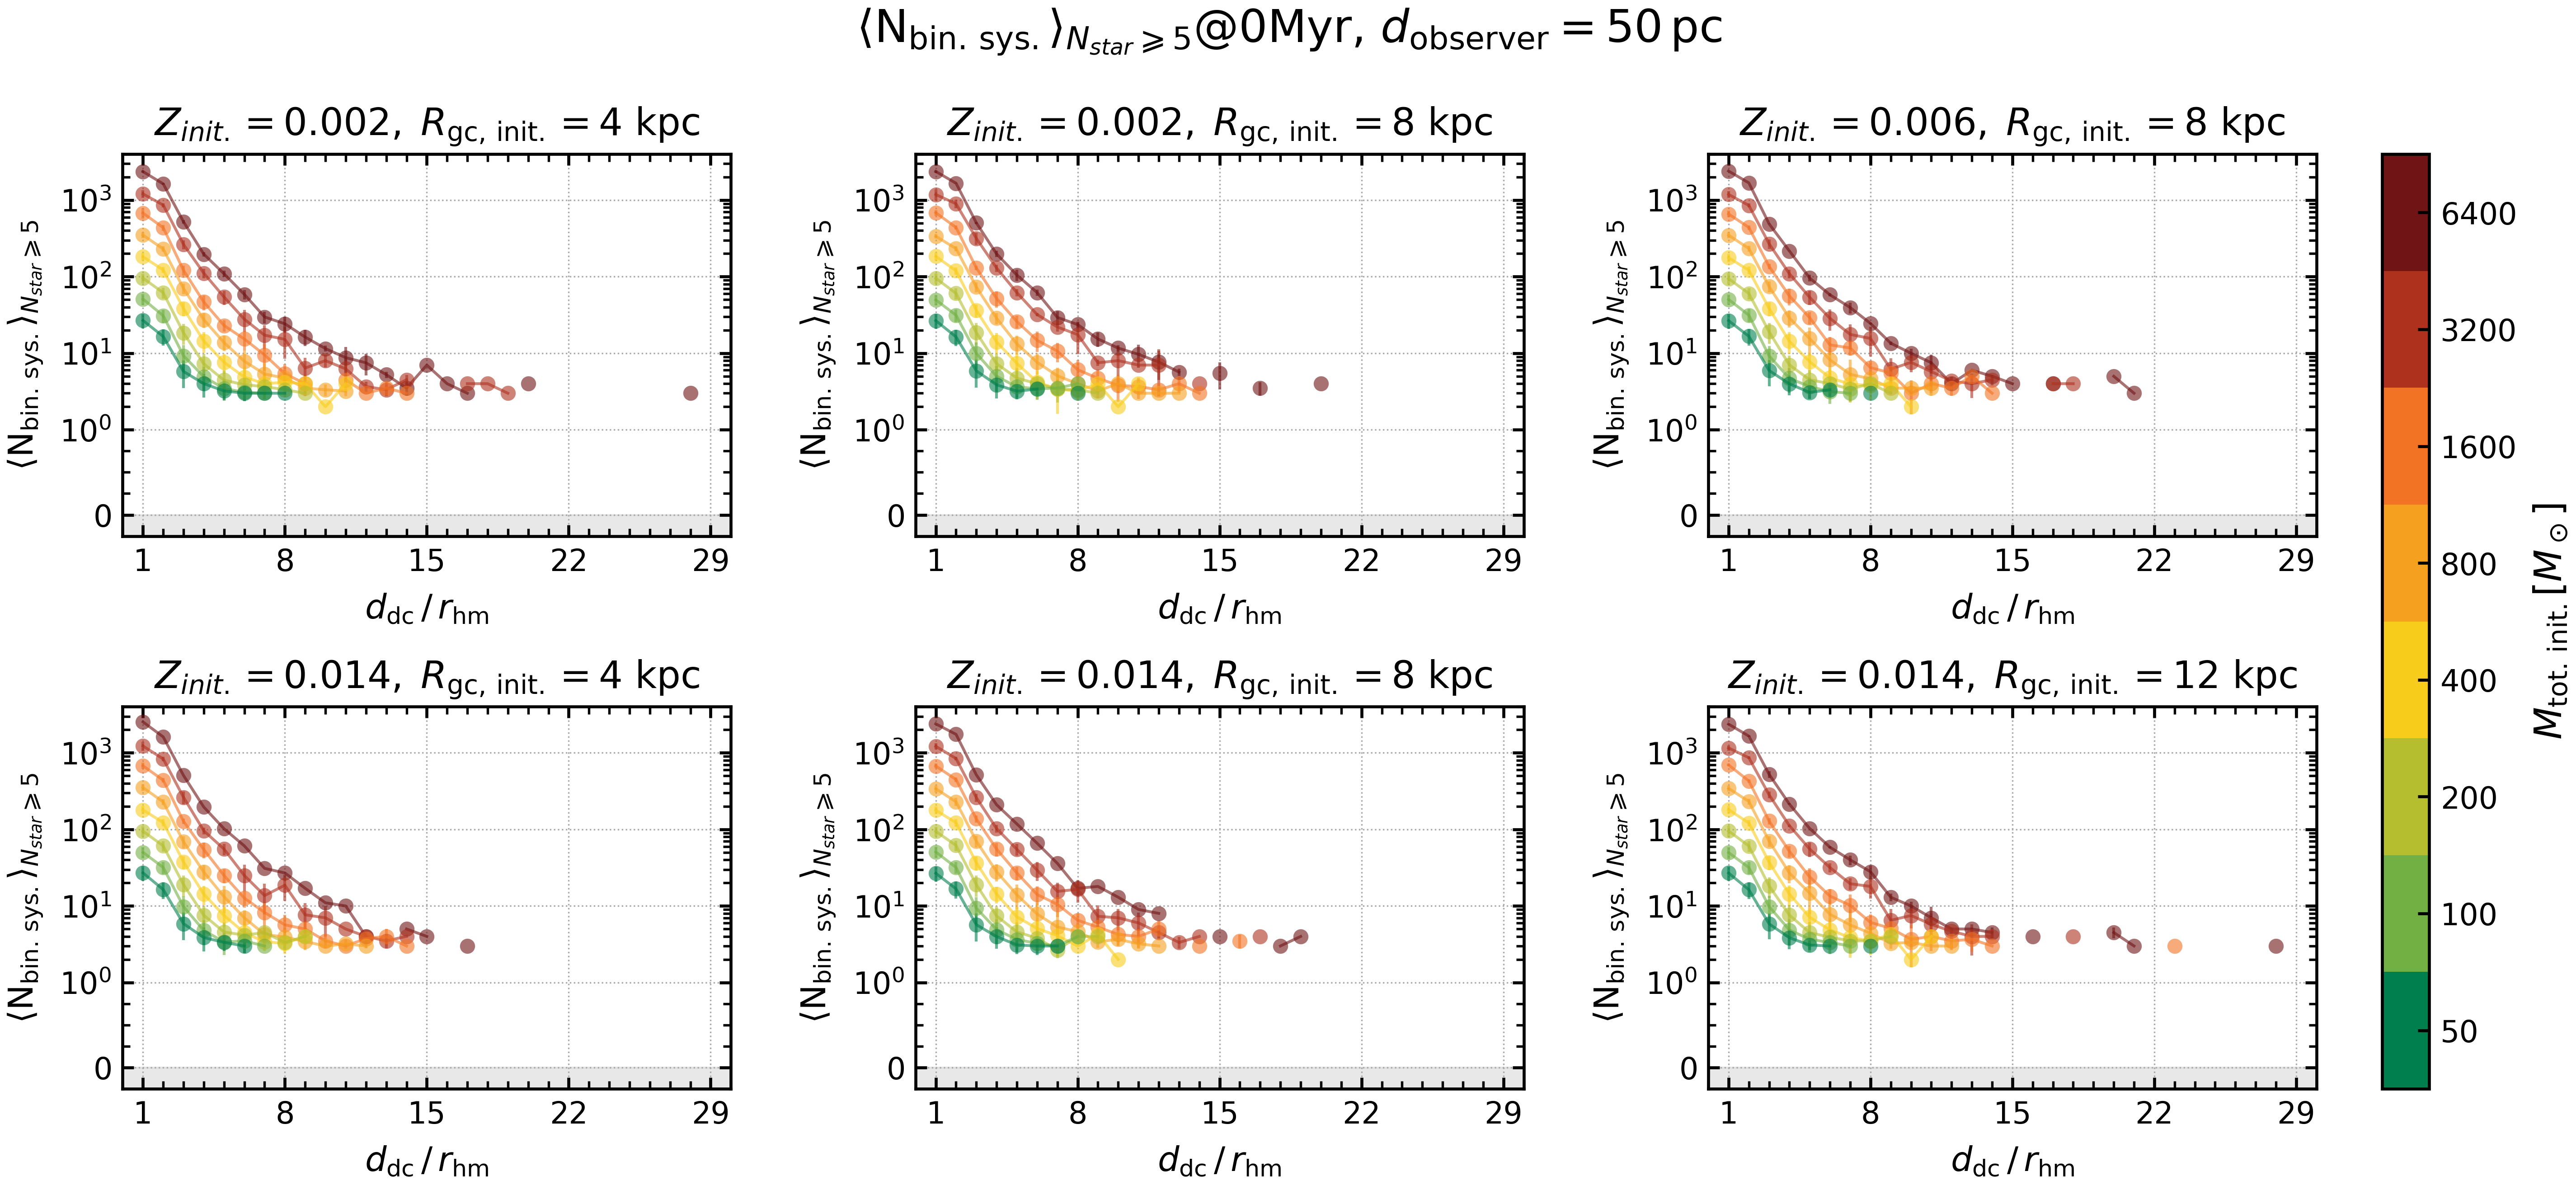

In [ ]:
target_timestamps = [0, 1, 10, 50, 100, 200, 300]

for comb_idx, (timestamp_to_plot, metric_to_plot) in (
    combine_pbar := tqdm(
        enumerate(
            product(
                target_timestamps,
                list(metric_dict.keys()),
            )
        ),
        total=len(target_timestamps) * len(metric_dict),
        leave=False,
        dynamic_ncols=True,
    )
):
    combine_pbar.set_description(
        f"Plotting `{metric_to_plot}` @ {timestamp_to_plot}Myr"
    )

    # setup export path
    fig_export_path = OUTPUT_BASE / "figures" / "filtered_annular" / f"{metric_to_plot}"
    fig_export_path.mkdir(parents=True, exist_ok=True)

    # plot figure
    plot_df = aggregated_df[aggregated_df["timestamp"] == timestamp_to_plot].copy()
    radii = sorted([r for r in plot_df["radius"].unique() if r != 0])

    mass_levels = list(range(1, 9))
    cmap = mpl.colors.ListedColormap(
        [
            "#711415",
            "#ae311e",
            "#f37324",
            "#f6a020",
            "#f8cc1b",
            "#b5be2f",
            "#72b043",
            "#007f4e",
        ]
    )
    norm = mpl.colors.BoundaryNorm(
        boundaries=np.arange(0.5, 8.5 + 1, 1), ncolors=cmap.N
    )

    attr_pairs = [(2, 4), (2, 8), (6, 8), (14, 4), (14, 8), (14, 12)]

    for fig_idx, (dist_pc, group_df) in (
        dist_pbar := tqdm(
            enumerate(plot_df.groupby("galactic_x", observed=True, sort=False)),
            total=plot_df["galactic_x"].nunique(),
            leave=False,
            dynamic_ncols=True,
        )
    ):
        dist_pbar.set_description(f"Plotting distance={dist_pc} pc")

        fig, axs = plt.subplots(
            nrows=2,
            ncols=3,
            figsize=(19, 8),
            dpi=300,
            constrained_layout=True,
            gridspec_kw=dict(hspace=0.06, wspace=0.08),
        )

        metric_label_tex, metric_formula_tex = metric_dict[metric_to_plot]
        # number
        if metric_formula_tex is None:
            metric_title = metric_label_tex
            y_scale_dict = {"scale": "symlog", "linthresh": 1}
            y_plot_range = (-0.25, 4000)
            y_major_locator = mpl.ticker.SymmetricalLogLocator(
                base=10.0,
                linthresh=y_scale_dict["linthresh"],
                subs=[1.0],
            )
            y_minor_locator = mpl.ticker.FixedLocator(
                [0, 0.25, 0.5, 0.75]
                + [i * 10**j for j in range(0, 4) for i in range(2, 10)]
            )
            y_tick_label_formatter = None

        # fraction
        else:
            metric_title = f"{metric_label_tex}={metric_formula_tex}"
            y_scale_dict = {"scale": "linear"}
            y_plot_range = (-0.1, 1.1)
            y_major_locator = mpl.ticker.MultipleLocator(0.2)
            y_minor_locator = mpl.ticker.MultipleLocator(0.1)
            y_tick_label_formatter = mpl.ticker.FormatStrFormatter("%.1f")

        fig.suptitle(
            rf"$\langle \mathrm{{{metric_label_tex}}} \rangle_{{N_{{star}}\geqslant5}}$"
            rf"@{timestamp_to_plot}Myr, "
            rf"$d_\mathrm{{observer}}={dist_pc}\,\mathrm{{pc}}$",
            fontsize=24,
            y=1.04,
            va="bottom",
        )

        for (init_metallicity, init_gc_radius), ax in zip(attr_pairs, axs.flat):
            subgroup = group_df[
                (group_df["init_metallicity"] == init_metallicity)
                & (group_df["init_gc_radius"] == init_gc_radius)
            ]

            for mass_lv in mass_levels:
                mass_df = (
                    subgroup[subgroup["init_mass_lv"] == mass_lv]
                    .set_index("radius")
                    .reindex(radii)
                )
                if mass_df.empty:
                    continue

                ax.errorbar(
                    radii,
                    mass_df[(metric_to_plot, "mean")].to_numpy(),
                    yerr=mass_df[(metric_to_plot, "std")].to_numpy(),
                    fmt="o-",
                    capsize=3,
                    markersize=8,
                    markeredgewidth=0,
                    color=cmap(norm(mass_lv)),
                    alpha=0.6,
                    label=f"M={mass_lv}",
                )

            if metric_formula_tex is not None:
                ax.axhspan(y_plot_range[0], 0, color="lightgrey", alpha=0.5, zorder=-1)
                ax.axhspan(
                    1, y_plot_range[1] * 10, color="lightgrey", alpha=0.5, zorder=-1
                )
            else:
                ax.axhspan(-1, 0, color="lightgrey", alpha=0.5, zorder=-1)

            ax.set_xlim(0, 30)
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(7, offset=1))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
            ax.set_xlabel(r"$d_\mathrm{dc}\,/\,r_\mathrm{hm}$")

            ax.set_yscale(
                y_scale_dict.get("scale", "linear"),
                **{k: v for k, v in y_scale_dict.items() if k != "scale"},
            )
            ax.set_ylim(*y_plot_range)
            ax.yaxis.set_major_locator(y_major_locator)
            ax.yaxis.set_minor_locator(y_minor_locator)
            if y_tick_label_formatter:
                ax.yaxis.set_major_formatter(y_tick_label_formatter)
            ax.set_ylabel(
                rf"$\langle \mathrm{{{metric_label_tex}}} \rangle_"
                r"{{N_{{star}}\geqslant5}}$"
            )

            ax.set_title(
                rf"$Z_{{init.}}={init_metallicity * 10e-4},\;"
                rf"R_\mathrm{{gc,\,init.}}={init_gc_radius}\ \mathrm{{kpc}}$",
                fontsize=20,
                y=1.02,
            )

            ax.grid(ls=":", lw=0.8, c="darkgrey")

        mass_values = [12800 / (2**m) for m in mass_levels]
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        cbar = fig.colorbar(
            sm,
            ax=axs,
            orientation="vertical",
            fraction=0.08,
            pad=0.03,
            # ticks=mass_levels,
        )
        cbar.ax.invert_yaxis()
        cbar.set_ticks(mass_levels)
        cbar.set_ticklabels([f"{int(mass)}" for mass in mass_values])
        cbar.set_label(
            # r"$M_\mathrm{tot.\,init.}=\dfrac{12\,800}{2^N}M_\odot$", fontsize=20
            r"$M_\mathrm{tot.\,init.} [M_\odot]$",
            fontsize=20,
        )
        cbar.ax.tick_params(which="major", direction="in", length=6)
        cbar.ax.tick_params(which="minor", length=0)

        if (timestamp_to_plot == target_timestamps[0]) and (fig_idx == 0):
            plt.show()
        else:
            plt.close(fig)
        fig.savefig(
            fig_export_path
            / f"annular-{metric_to_plot}-{dist_pc}pc-{timestamp_to_plot}Myr.png",
            bbox_inches="tight",
            dpi=300,
        )
    #     break
    # break